In [205]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

For reproducibility and consistency across runs, we will set a seed

In [206]:
def set_random_seeds(seed=1):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
set_random_seeds(seed=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(torch.cuda.get_device_name(0))  # Prints the GPU name

Using device: cuda
NVIDIA GeForce RTX 4060 Laptop GPU


In [207]:
def load_mnist_data(batch_size=256, download=True):
    """
    Loads and returns MNIST train and test DataLoaders with flattened images.
    
    Args:
        batch_size (int): The batch size for the DataLoader.
        download (bool): Whether to download the dataset if not found.
    
    Returns:
        train_loader, test_loader: DataLoader objects for the MNIST dataset.
    """
    # Define a transform to normalize and flatten the data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: x.view(-1))  # flatten image to a 1D vector of size 784
    ])
    
    # Load the training and test datasets
    train_dataset = datasets.MNIST(root='../datasets', train=True, transform=transform, download=download)
    test_dataset = datasets.MNIST(root='../datasets', train=False, transform=transform, download=download)
    
    # Create DataLoaders for the datasets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

In [208]:
class Autoencoder(nn.Module):
    """
    Autoencoder with a bottleneck of size 2 that maps MNIST images to a 2D latent space.
    Includes training, evaluation, and embedding extraction methods.
    """
    
    ### NOTES ###
    # Might have to use batchnorm to impose a structure on the latent space

    def __init__(self, latent_dim=2, hidden_size=128, use_batchnorm=True):
        super().__init__()
        # Encoder layers
        # 784 -> 128 -> 2
        encoder_layers = [
            nn.Linear(28 * 28, hidden_size), # asuming size 28x28 of the images
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, latent_dim), # the size 2 bottleneck layer
            nn.BatchNorm1d(latent_dim)
        ]
        self.encoder = nn.Sequential(*encoder_layers) # '*' is unpacking the list into it's elements

        # Decoder layers
        # 2 -> 128 -> 784
        decoder_layers = [
            nn.Linear(latent_dim, hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, 28 * 28),
            nn.Sigmoid() # normalize outputs to [0, 1] - grayscale
        ]
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        """
        Encodes an input batch (e.g., MNIST images) into the latent space.
        
        Args:
            x (Tensor): Input images of shape [batch_size, 784].
        Returns:
            z (Tensor): Encoded latent vectors of shape [batch_size, latent_dim].
        """

        z = self.encoder(x)
        return z


    def decode(self, z):
        """
        Decodes latent vectors back to the original image space.
        
        Args:
            z (Tensor): Latent vectors of shape [batch_size, latent_dim].
        Returns:
            x_rec (Tensor): Reconstructed images of shape [batch_size, 784].
        """

        x_rec = self.decoder(z)
        return x_rec

    def forward(self, x):
        """
        Complete forward pass: encode then decode.
        
        Args:
            x (Tensor): Input images.
        Returns:
            reconstructed (Tensor): Reconstructed images of the same shape as x.
        """
        reconstructed = self.decode(self.encode(x))
        return reconstructed

    def train_one_epoch(self, train_loader, optimizer, criterion, device='cuda'):
        """
        Performs one epoch of training.
        
        Args:
            train_loader (DataLoader): DataLoader for the training set.
            optimizer (torch.optim.Optimizer): Optimizer for model parameters.
            criterion: Loss function (e.g., MSELoss, BCELoss).
            device (str): 'cpu' or 'cuda' device.
        
        Returns:
            epoch_loss (float): Average loss across this training epoch.
        """
        loss_total = 0.0
        self.train()

        for x, _ in train_loader:
            x = x.to(device)
            # Computing loss
            reconstructed = self.forward(x)
            loss = criterion(reconstructed, x)
            loss_total += loss.item()
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_loss = loss_total / len(train_loader) # Computing average loss in epoch
        return epoch_loss

    def evaluate(self, data_loader, criterion, device='cuda'):
        """
        Evaluates the autoencoder on a given dataset (test or validation).
        
        Args:
            data_loader (DataLoader): DataLoader for the evaluation set.
            criterion: Loss function for reconstruction.
            device (str): 'cpu' or 'cuda'.
        
        Returns:
            eval_loss (float): Average reconstruction loss on this dataset.
        """
        self.eval() # Disable gradient computation
        loss_total = 0.0
        with torch.no_grad():
            for x, _ in data_loader:
                x = x.to(device)
                # Computing loss
                reconstructed = self.forward(x)
                loss = criterion(reconstructed, x)
                loss_total += loss.item()

        eval_loss = loss_total / len(data_loader) # Computing average evaluation loss
        return eval_loss

    def fit(self, train_loader, test_loader, num_epochs, lr=1e-3, device='cuda', verbose=True):
        """
        High-level method to train the autoencoder for a given number of epochs.
        It orchestrates optimizer setup, training loop, and evaluation per epoch.
        
        Args:
            train_loader (DataLoader): DataLoader for training set.
            test_loader (DataLoader): DataLoader for test/validation set.
            num_epochs (int): Number of epochs.
            lr (float): Learning rate for the optimizer.
            device (str): 'cpu' or 'cuda'.
            verbose (bool): Each epoch prints loss if True
        
        Returns:
            train_losses (list of float): Loss for each training epoch.
            test_losses (list of float): Loss for each test epoch.
        """
        self.to(device)
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        loss_function = nn.MSELoss()

        train_loss_list = []
        test_loss_list = []
        # Fitting the model
        for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
            # Train loss
            train_loss = self.train_one_epoch(train_loader, optimizer, criterion=loss_function,device=device)
            train_loss_list.append(train_loss)
            # Test loss
            test_loss = self.evaluate(test_loader, criterion=loss_function, device=device)
            test_loss_list.append(test_loss)
            if verbose:
                print(f'Epoch #{epoch}')
                print(f'Train Loss = {train_loss:.3e} --- Test Loss = {test_loss:.3e}')
        
        return train_loss_list, test_loss_list

    def get_latent_embeddings(self, data, device='cuda'):
        """
        Passes the entire dataset through the encoder to extract latent vectors.
        
        Args:
            data_loader (DataLoader): DataLoader for the dataset to encode.
            device (str): 'cpu' or 'cuda'.
        
        Returns:
            embeddings (Tensor): Concatenated latent vectors of shape [N, latent_dim].
            labels (Tensor): Corresponding labels (if available) of shape [N].
        """
        
        self.eval() # Disable gradient computation
        with torch.no_grad():
            z = self.encode(data)

        return z


In [209]:
def select_anchors(embeddings, num_anchors=10):
    """
    Selects a subset of embeddings to use as 'anchors' for relative representation.
    
    Args:
        embeddings (Tensor or array): Shape [N, latent_dim].
        num_anchors (int): Number of anchors to select.
    
    Returns:
        anchors: A (num_anchors, latent_dim) subset of the original embeddings.
    """
    anchors_index = np.random.choice(embeddings.shape[0], size=num_anchors, replace=False)
    anchors = embeddings[anchors_index]
    return anchors

def compute_relative_coordinates(embeddings, anchors, flatten=False):
    """
    Transforms 'embeddings' into a 'relative' coordinate system based on anchors.
    One approach could be subtracting an anchor or computing offsets.
    
    Args:
        embeddings (Tensor): Shape [N, latent_dim].
        anchors (Tensor): Shape [A, latent_dim], where A = num_anchors.
    
    Returns:
        relative_embeds (Tensor): The embeddings expressed relative to the anchors.
    """
    # we start off with normalizing the embeddings an the anchors
    # this way the cosine similarity is just the dot product between the word and anchor
    embeddings_norm = embeddings/np.linalg.norm(embeddings, axis=1)[:, np.newaxis]
    anchors_norm = anchors/np.linalg.norm(anchors, axis=1)[:, np.newaxis]
    reletive_reps = []
    for embedding in embeddings_norm:
        if flatten:
            embedding = embedding.flatten()
        
        reletive_rep = np.array([np.dot(embedding, anchor) for anchor in anchors_norm])
        reletive_reps.append(reletive_rep)
    reletive_reps = np.array(reletive_reps)
    return reletive_reps


In [210]:
def run_experiment(num_epochs=5, batch_size=256, lr=1e-3, device='cuda', anchors_num=2, latent_dim = 2, hidden_layer = 128, trials=1):
    """
    Orchestrates the autoencoder pipeline:
      1. Load data
      2. Initialize the autoencoder
      3. Train and evaluate
      4. Extract embeddings
      5. (Optional) Select anchors, compute relative coordinates
    
    Args:
        num_epochs (int): Number of training epochs.
        batch_size (int): DataLoader batch size.
        lr (float): Learning rate.
        device (str): 'cpu' or 'cuda' device.
        latent_dim (int): Dimension of the AE's latent space (2 for easy visualization).
    
    Returns:
        model: Trained autoencoder.
        embeddings (Tensor): Latent embeddings from the test (or train) set.
        anchors (Tensor): (Optional) set of anchor embeddings if you implement that step here.
    """
    # create the data loader
    train_loader, test_loader = load_mnist_data()

    # extact the data to select anchors
    all_features = []
    all_labels = []

    for features, labels in train_loader:
        # Move to CPU if they are on GPU (if you're using CUDA)
        features = features.cpu()
        labels = labels.cpu()

        all_features.append(features)
        all_labels.append(labels)

    # Concatenate all batches into a single tensor
    all_features = torch.cat(all_features, dim=0)
    rel_rep_labels = torch.cat(all_labels, dim=0).detach().numpy()

    # select anchors
    anchors = select_anchors(all_features, num_anchors=anchors_num)
    rel_reps_list = []
    encodings_list = []
    for i in range(trials):
        set_random_seeds(i+1)
        print(f"Trial {i+1} of {trials}")
        AE = Autoencoder(latent_dim=latent_dim, hidden_size=hidden_layer)
        train_loss, test_loss = AE.fit(train_loader, test_loader, num_epochs, lr, device=device, verbose=False)

        encodings_data = AE.get_latent_embeddings(all_features.cuda(),device=device)
        encodings_anchor = AE.get_latent_embeddings(anchors.cuda(),device=device)

        # Convert to numpy if needed
        encodings_data_np = encodings_data.cpu().detach().numpy()
        encodings_anchor_np = encodings_anchor.cpu().detach().numpy()
        rel_reps = compute_relative_coordinates(encodings_data_np, encodings_anchor_np)
        rel_reps_list.append(rel_reps)
        encodings_list.append(encodings_data_np)
    return encodings_list, rel_rep_labels, rel_reps_list, rel_rep_labels
encodings, labels, rel_reps, rel_rep_labels = run_experiment(device=device, latent_dim=10, anchors_num=2, trials=4)

Trial 1 of 4


Training Epochs: 100%|██████████| 5/5 [00:33<00:00,  6.62s/it]


Trial 2 of 4


Training Epochs: 100%|██████████| 5/5 [00:32<00:00,  6.53s/it]


Trial 3 of 4


Training Epochs: 100%|██████████| 5/5 [00:32<00:00,  6.48s/it]


Trial 4 of 4


Training Epochs: 100%|██████████| 5/5 [00:31<00:00,  6.33s/it]


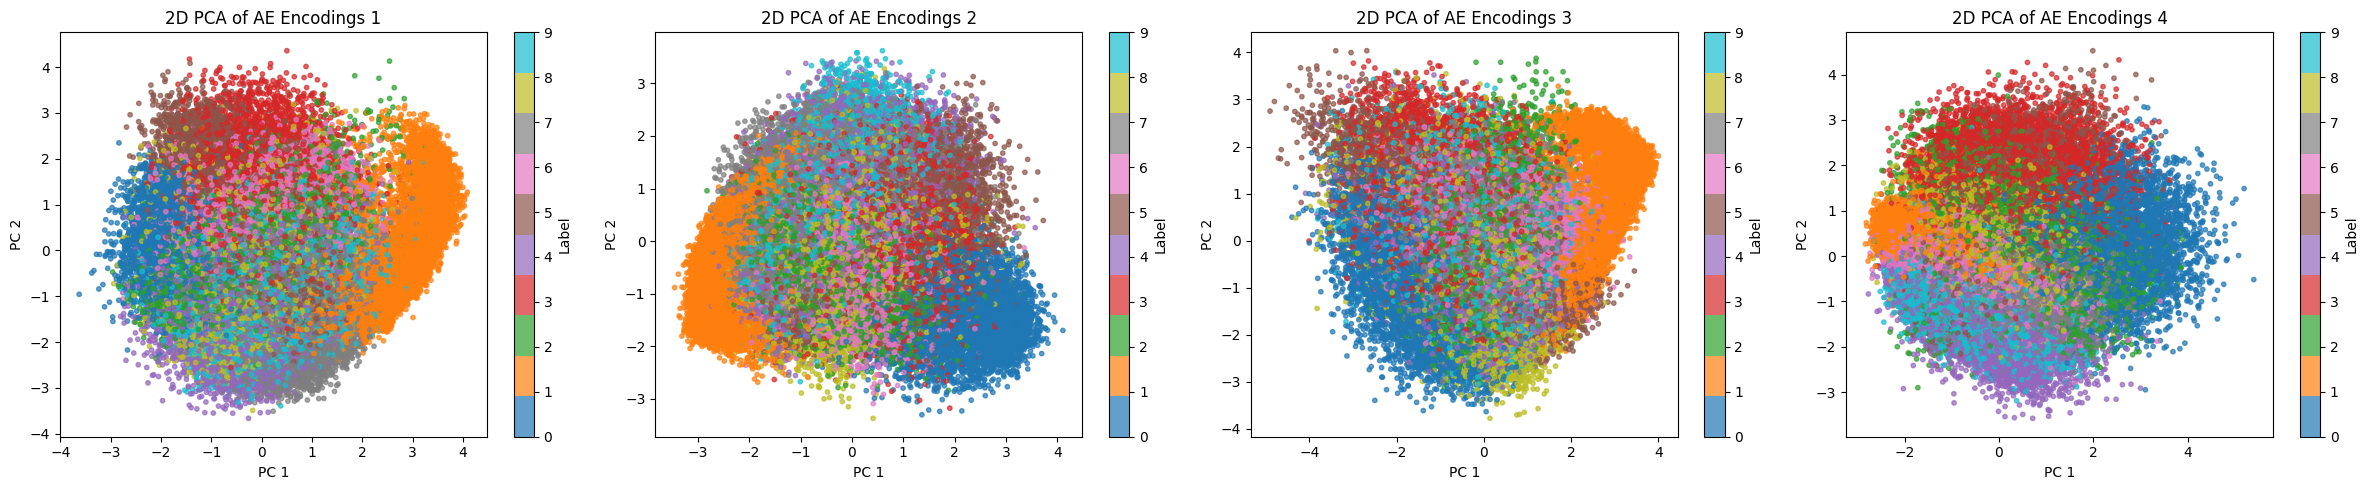

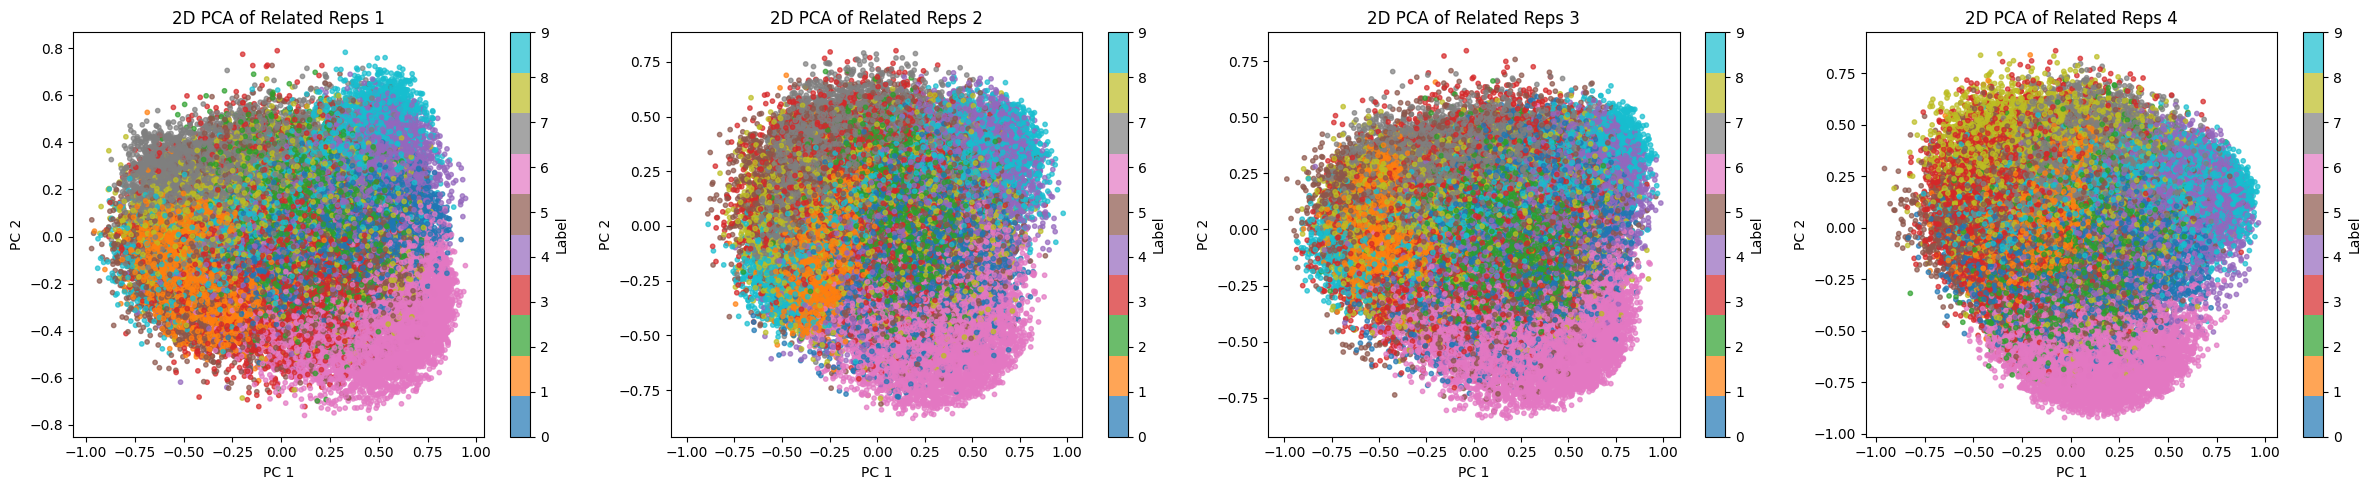

In [211]:
import numpy as np


def fit_and_align_pca(data, ref_pca=None):
    """
    Fits PCA on 'data', then aligns its components with the reference PCA 
    so that signs are consistent. Returns (pca, data_pca), where pca
    is the fitted PCA object and data_pca is the 2D projection.

    If ref_pca is None, this PCA becomes the new reference.
    If ref_pca is not None, the new PCA is aligned (sign-flipped if needed)
    to match the reference's orientation.
    """
    pca = PCA(n_components=2, random_state=42)
    data_pca = pca.fit_transform(data)
    
    if ref_pca is None:
        # First time: no reference to align with, just return
        return pca, data_pca
    
    # Align the sign of the new components with the reference
    for i in range(2):
        dot_product = np.dot(pca.components_[i], ref_pca.components_[i])
        if dot_product < 0:
            pca.components_[i] = -pca.components_[i]
            data_pca[:, i]     = -data_pca[:, i]
    
    return data_pca


def plot_data_list(data_list, labels, do_pca=True, ref_pca=None,
                   is_relrep=True):
    """
    Plots multiple datasets side-by-side in subplots (1 row, len(data_list) columns).
    
    data_list : list of np.ndarray
        Each element is a dataset (shape [n_samples, n_features]).
    label_list : list of np.ndarray
        Each element is the label array for the corresponding dataset.
    do_pca : bool
        Whether to run PCA on the data. If True, we use fit_and_align_pca.
    ref_pca : PCA or None
        If None, the first dataset's PCA becomes the reference.
        If not None, subsequent datasets align to this PCA orientation.
    get_ref_pca : bool
        If True, return the final PCA used for alignment (could be the first one).
    is_relrep : bool
        If True, changes the plot title to "Related Representations", else "AE Encodings".
    """
    
    n_plots = len(data_list)
    fig, axs = plt.subplots(1, n_plots, figsize=(6*n_plots, 5), squeeze=False)
    axs = axs.ravel()  # Flatten in case there's only 1 subplot
    
    for i, data in enumerate(data_list):
        if do_pca:
            if ref_pca is None:
                pca, data_2d = fit_and_align_pca(data, ref_pca=ref_pca)
            else:
                if is_relrep:
                    data_2d = fit_and_align_pca(data, ref_pca=ref_pca)
                else:
                    _, data_2d = fit_and_align_pca(data, ref_pca=None)

            # If we didn't already have a reference, the first fitted pca becomes ref
            if i == 0 and ref_pca is None:
                ref_pca = pca
        else:
            data_2d = data
        
        scatter = axs[i].scatter(data_2d[:, 0], data_2d[:, 1],
                                 c=labels, cmap='tab10', s=10, alpha=0.7)
        # Optionally add a colorbar to each subplot
        cb = fig.colorbar(scatter, ax=axs[i], ticks=range(10))
        cb.set_label('Label')
        
        axs[i].set_xlabel('PC 1')
        axs[i].set_ylabel('PC 2')
        if is_relrep:
            axs[i].set_title(f'2D PCA of Related Reps {i+1}')
        else:
            axs[i].set_title(f'2D PCA of AE Encodings {i+1}')
    
    plt.tight_layout()
    plt.show()


# ----------------------------------------------------------------
# Example usage (with dummy data):
# ----------------------------------------------------------------

# Plot encodings side by side
plot_data_list(encodings, 
                labels,
                do_pca=True, is_relrep=False)

# Plot rel_reps side by side with sign alignment
plot_data_list(rel_reps, 
                            labels,
                            do_pca=True, ref_pca=None, is_relrep=True)

